In [1]:
import numpy as np
from rdkit.Chem import AllChem as Chem
import pandas as pd
from rdkit.Chem import rdMolDescriptors
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from umap import UMAP
import seaborn

In [2]:
mtor = pd.read_csv("../../data/chembl_mtor_ic50.csv", delimiter=";")
mtor = mtor[["Molecule ChEMBL ID", "Smiles"]]
mtor["mol"] = mtor.apply(lambda row: Chem.MolFromSmiles(row["Smiles"]), axis=1)
mtor["Source"] = "mtor"
mtor.rename({"Molecule ChEMBL ID":"ID"}, axis=1, inplace=True)

drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

df = pd.concat([mtor, pd_drugbank]).reset_index(drop=True)
df["c"] = df.apply(lambda row: row["mol"].HasSubstructMatch(Chem.MolFromSmarts("[#6]")), axis=1)
df = df[df["c"]].drop(columns=["c"]).reset_index(drop=True)

[12:20:43] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:20:43] ERROR: Could not sanitize molecule ending on line 20009
[12:20:43] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:20:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:20:44] ERROR: Could not sanitize molecule ending on line 250947
[12:20:44] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:20:44] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:20:44] ERROR: Could not sanitize molecule ending on line 258130
[12:20:44] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:20:44] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:20:44] ERROR: Could not sanitize molecule ending on line 261581
[12:20:44] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:20:44] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:20:44] ERROR: Could not sanitize

In [3]:
data = df.join(
    pd.DataFrame(
        (rdMolDescriptors.MQNs_(mol) for mol in df["mol"]), 
        columns=[f"MQN{i}" for i in range(1,43)]))

In [4]:
norm = preprocessing.normalize(data.drop(columns=["ID", "Smiles", "mol", "Source"]))

In [5]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(norm), columns=["PC1", "PC2"])
pca_data["Source"] = df["Source"]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

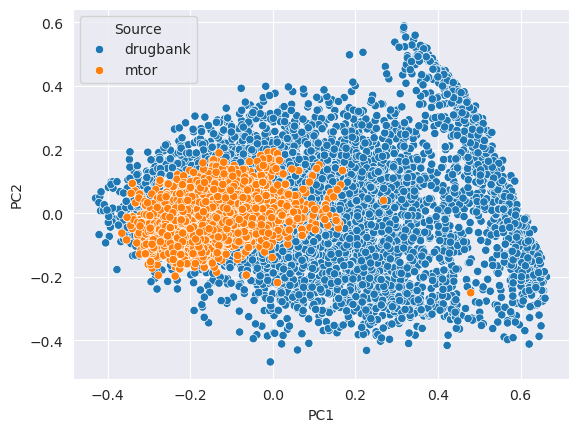

In [6]:
seaborn.scatterplot(pca_data.sort_values("Source"), x="PC1", y="PC2", hue="Source")

In [7]:
um = UMAP()
um_data = um.fit_transform(norm)
um_data = pd.DataFrame(um_data, columns=["UMAP_1", "UMAP_2"])
um_data["Source"] = df["Source"]

<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

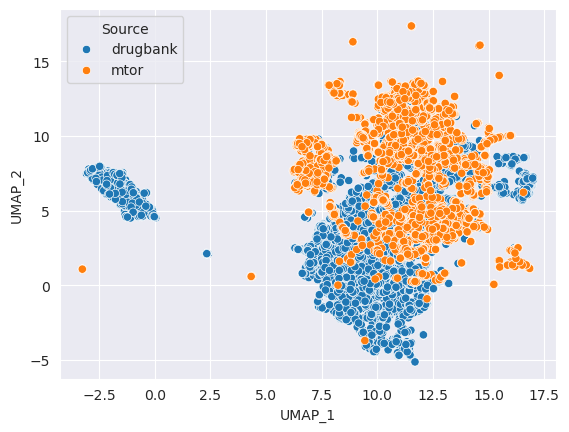

In [8]:
seaborn.scatterplot(um_data.sort_values("Source"), x="UMAP_1", y="UMAP_2", hue="Source")

In [9]:
tsne = TSNE()
tsne_data = tsne.fit_transform(norm)
tsne_data = pd.DataFrame(tsne_data, columns=["tSNE_1", "tSNE_2"])
tsne_data["Source"] = df["Source"]

<AxesSubplot:xlabel='tSNE_1', ylabel='tSNE_2'>

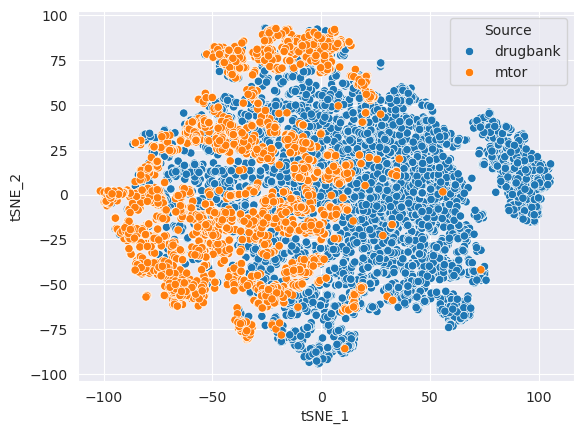

In [10]:
seaborn.scatterplot(tsne_data.sort_values("Source"), x="tSNE_1", y="tSNE_2", hue="Source")

distanční matice pro fingerprinty přes jaccardovu vzdálenost

In [4]:
df["fp"] = df.apply(lambda row: np.array(Chem.GetMorganFingerprintAsBitVect(row["mol"], 3, 1024).ToList(), dtype=np.bool_), axis=1)

In [5]:
arr = np.vstack(df["fp"].values)

In [6]:
dist = pairwise_distances(arr, metric="jaccard", n_jobs=-1)

In [9]:
tsne = TSNE(n_components=2, metric="precomputed", init="random")
tsne_data = tsne.fit_transform(dist)

<AxesSubplot:xlabel='t-SNE-1', ylabel='t-SNE-2'>

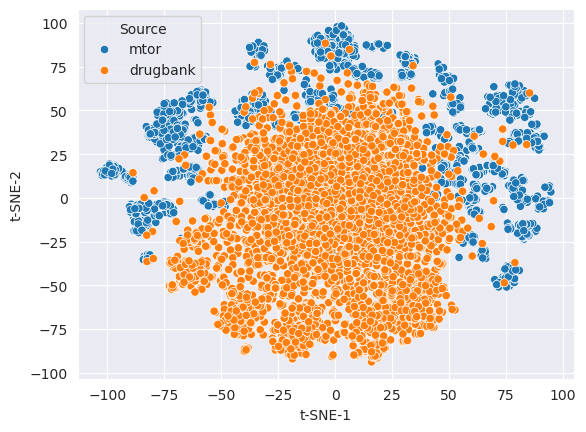

In [15]:
tsne_df = pd.DataFrame(tsne_data, columns=["t-SNE-1", "t-SNE-2"])
tsne_df["Source"] = df["Source"]
seaborn.scatterplot(tsne_df, x="t-SNE-1", y="t-SNE-2", hue="Source")